In [17]:
#import pip
#pip.main(['install','seaborn']);
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

MIDNIGHT = 24*60*60
double_figsize=(12,5)

def return_activity_duration(start_time, end_time):
    if(start_time == np.nan or end_time == np.nan):
        return np.nan
    
    if(start_time > end_time):
        return abs(start_time + (MIDNIGHT - end_time))

    return abs(end_time - start_time)
#output_path = 'C:\\Users\\Anna\\Metacity\\Metacity-SynthPop\\output\\'
output_path = "/home/metamat/anicka/Metacity-SynthPop/output/"

# Srovnání syntetické populace a vstupních dat

## Načtení HTS dat

In [18]:
df_hts = pd.read_csv(output_path+'csv/clean_hts_matched.csv', index_col=[0])
display(df_hts.head(2))

,traveler_id,household_id,sex,age,employment,trip_today,age_class,district_name
0,1,1306,M,12,student,True,0,Praha-Čakovice
1,2,1306,F,46,employed,True,3,Praha-Čakovice


## Načtení dat SLDB 2011

In [19]:
df_sp = pd.read_csv(output_path+'csv/clean_census_matched.csv', index_col=[0])
display(df_sp.head(2))


,person_id,zone_id,sex,age,employment,age_class,district_name
0,1,554782423,F,34,employed,2,Praha-Libuš
1,19,554782423,F,29,employed,1,Praha-Libuš


## Porovnání základních údajů

sex


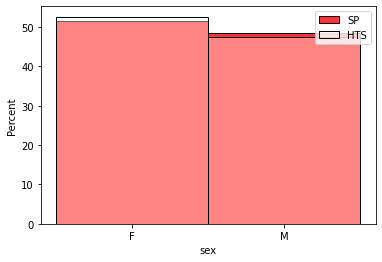

age


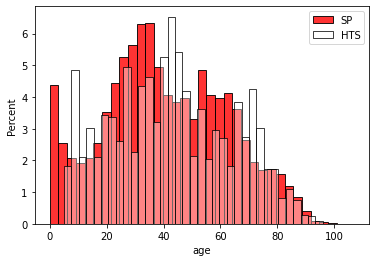

employment


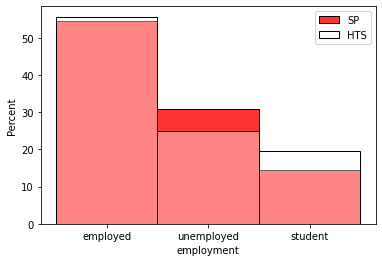

age_class


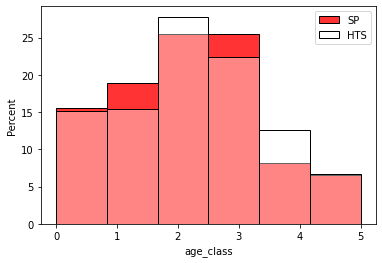

district_name


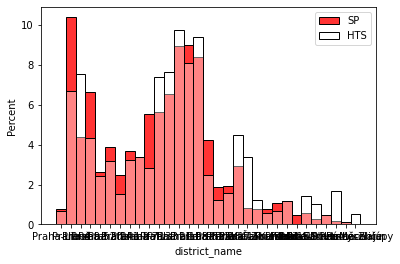

In [20]:
for column in ["sex","age","employment","age_class","district_name"]:
    print(column)
    f, ax = plt.subplots(1, 1)
    sns.histplot(ax=ax, x=column, data=df_sp, stat='percent', bins=min(35, len(df_sp[column].unique())), alpha=0.8, color="red")
    sns.histplot(ax=ax, x=column, data=df_hts, stat='percent', bins=min(35, len(df_hts[column].unique())), alpha=0.4, color="white")
    plt.savefig(output_path+'png/comparison_'+column+'.png')
    ax.legend(labels=["SP","HTS"])
    plt.show()

### Age split and socioeconomic status by age

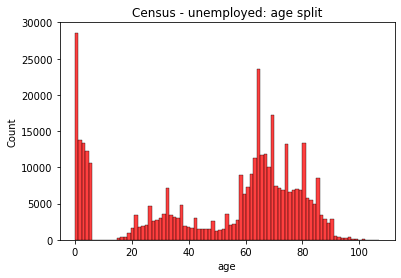

In [21]:
df_unemployed = df_sp[df_sp.employment == "unemployed"]
g = sns.histplot(x="age", data=df_unemployed, color="red")
g.set_title("Census - unemployed: age split")
plt.show()

In [22]:
df_c = pd.DataFrame()
df_c["age"] = df_sp.age.values
df_c["sex"] = df_sp.sex.values
df_c["employment"] = df_sp.employment.values
df_c["type"] = "census"

df_h = pd.DataFrame()
df_h["age"] = df_hts.age.values
df_h["sex"] = df_hts.sex.values
df_h["employment"] = df_hts.employment.values
df_h["type"] = "HTS"

df2 = pd.concat([df_c,df_h])


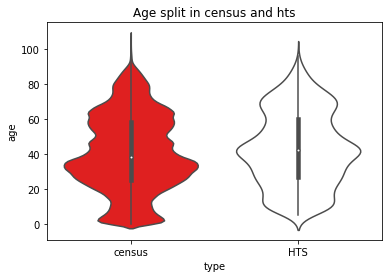

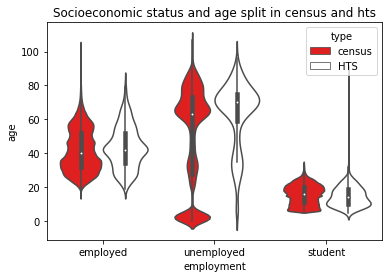

In [23]:
g = sns.violinplot(x="type", y="age", palette=["r","w"], data=df2)
g.set_title("Age split in census and hts")
plt.savefig(output_path+'png/comparison_age_split.png')
plt.show()
g = sns.violinplot(x="employment", y="age", hue="type", palette=["r","w"], data=df2)
g.set_title("Socioeconomic status and age split in census and hts")
plt.savefig(output_path+'png/comparison_age_se_status_split.png')
plt.show()

## Activity chains in HTS and SynthPop

#### Načtení dat z HTS

In [24]:
hts_trips = pd.read_csv(output_path+'csv/hts_trips_extracted.csv')
hts_activities = pd.read_csv(output_path+'csv/hts_activities_extracted.csv')
hts_activities["o_order"] = hts_activities.activity_order.values
hts_activities["d_order"] = hts_activities.activity_order.values
hts_activities["duration_m"] = hts_activities.apply(lambda row: return_activity_duration(row.start_time, row.end_time), axis=1)/60
hts_trips["o_order"] = hts_trips.trip_order
hts_trips["d_order"] = hts_trips.trip_order + 1


hts_joined_origin = hts_activities.merge(hts_trips, on=["traveler_id", "o_order"])
hts_joined_dest = hts_activities.merge(hts_trips, on=["traveler_id", "d_order"])

traveler_ids = hts_activities.traveler_id.unique()

#display(hts_activities.head(2))
#display(hts_trips.head(2))
#display(hts_joined_origin.head(2))

#### Načtení dat SynthPop

In [25]:
df_persons = pd.read_csv(output_path+'csv/df_persons.csv', index_col=[0])
df_persons.set_index("person_id", drop=True, inplace=True)
df_activities = pd.read_csv(output_path+'csv/df_activities.csv', index_col=[0])
df_trips = pd.read_csv(output_path+'csv/df_trips.csv', index_col=[0])

df_activities["o_order"] = df_activities.activity_order.values
df_activities["d_order"] = df_activities.activity_order.values
df_trips["o_order"] = df_trips.trip_order
df_trips["d_order"] = df_trips.trip_order + 1
df_joined_origin = df_activities.merge(df_trips, on=["person_id", "o_order"])
df_joined_dest = df_activities.merge(df_trips, on=["person_id", "d_order"])

df_activities = df_activities.merge(df_persons, on="person_id")
#df_merged = df_persons.merge(df_activities, on="person_id")

traveler_ids = df_activities.person_id.unique()
df_travelers = df_activities.groupby("person_id")

#display(df_persons.head(2))
#display(df_activities.head(2))
#display(df_trips.head(2))

### Comparison: Activity duration

In [26]:
def side_by_side(plots):
    figure, axes = plt.subplots(1, len(plots), figsize=double_figsize)

    for e,df in enumerate(plots):
        sns.histplot(df, ax=axes[e])

    plt.show()

def side_by_side_count(plots, columns, hues):
    figure, axes = plt.subplots(1, len(plots), figsize=double_figsize)

    for e,df in enumerate(plots):
        g = sns.countplot(x=df[columns[e]], 
                        order=['walk','pt','car','bike','ride'],
                        facecolor=(0, 0, 0, 0),
                        linewidth=3,
                   edgecolor=(0,0,0,1.0),
                        ax=axes[e])

        for p in g.patches:
            txt = str((p.get_height()/df.shape[0]*100).round(2)) + '%'
            #txt = str((p.get_height()).round(0)) + '#'
            txt_x = p.get_x()+0.1
            txt_y = p.get_height()/2
            g.text(txt_x,txt_y,txt)

    plt.show()


home


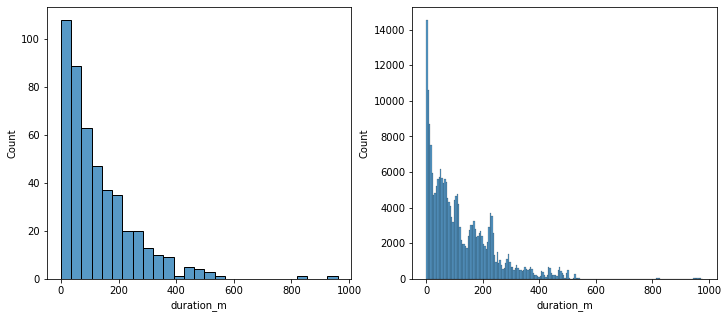

work


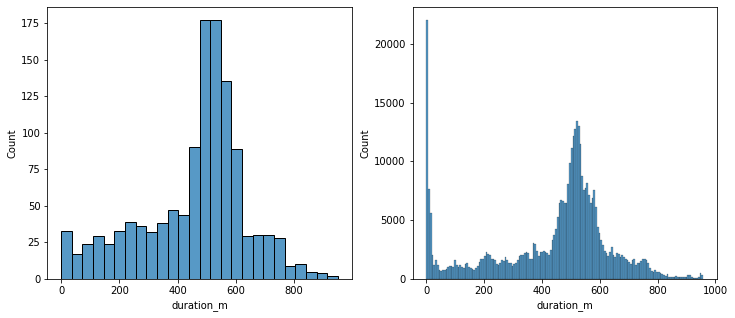

leisure


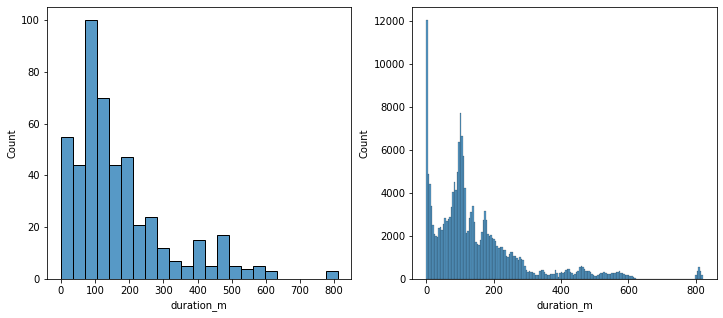

other


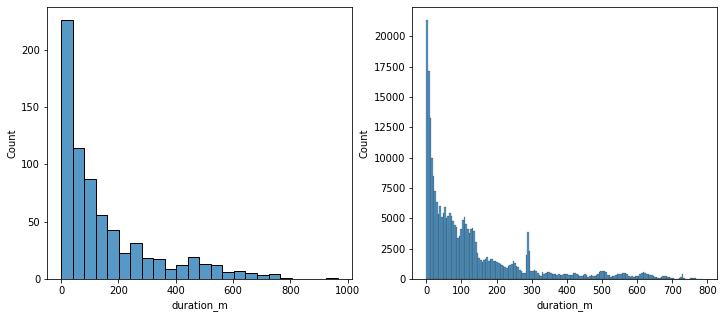

shop


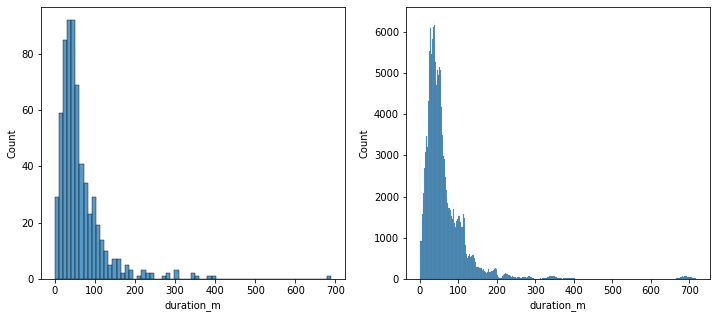

education


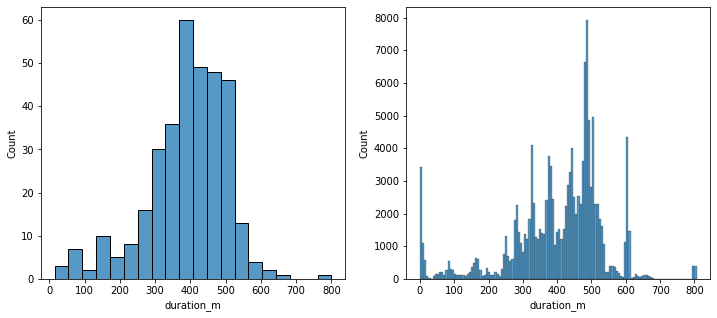

In [27]:
purposes = df_activities.purpose.unique()
for mode in purposes:
    print(mode)
    hts = hts_activities[hts_activities.purpose == mode]
    df = df_activities[df_activities.purpose == mode]
    
    side_by_side([hts.duration_m, df.duration_m])

### Comparison: Activity start time

home


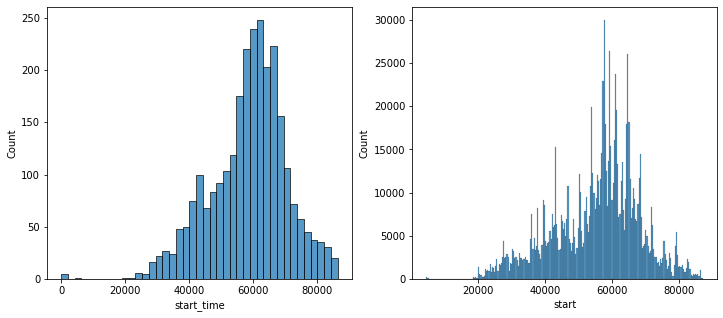

work


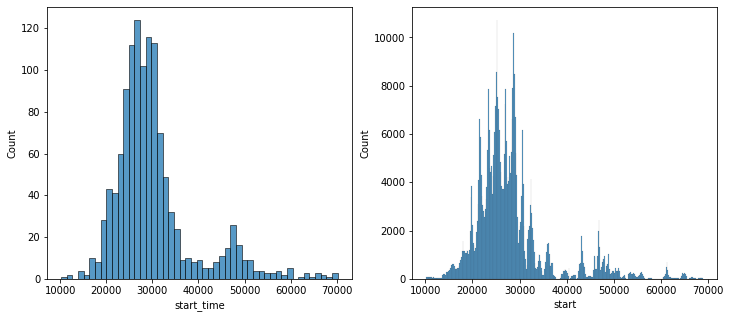

leisure


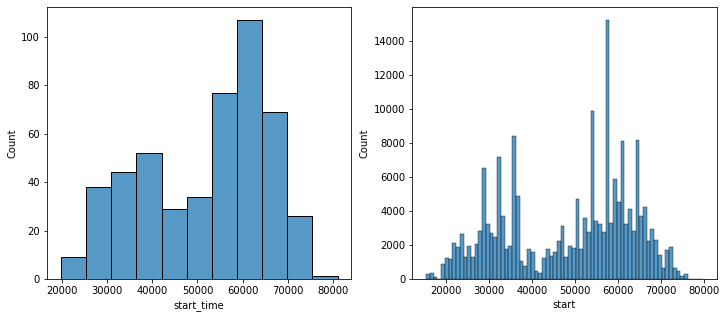

other


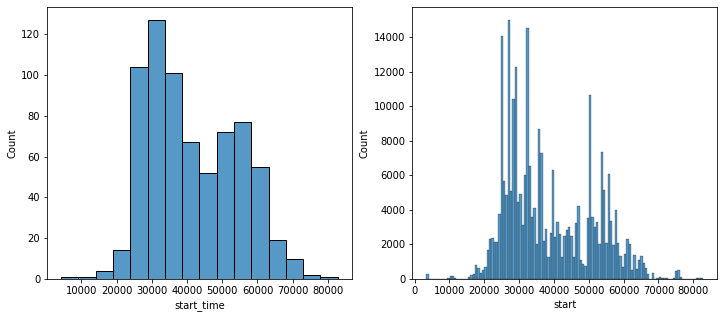

shop


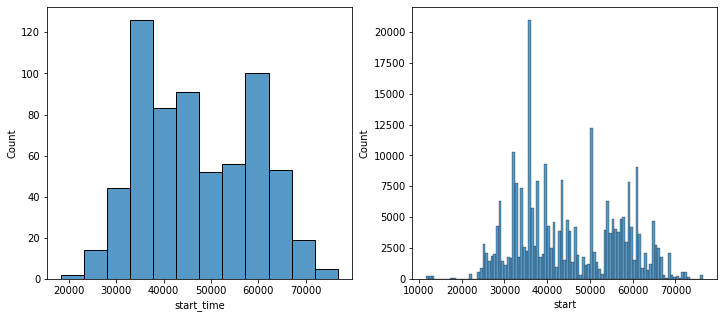

education


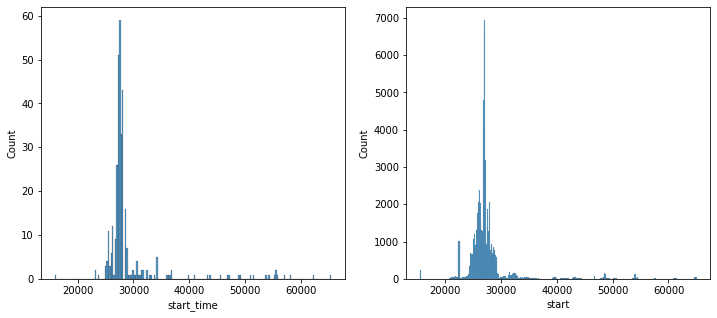

In [28]:
purposes = df_activities.purpose.unique()
for mode in purposes:
    print(mode)
    hts = hts_joined_dest[hts_joined_dest.purpose == mode]
    df = df_trips[df_trips.following_purpose == mode]
    
    side_by_side([hts.start_time, df.start])

### Comparison: activity count 

In [29]:
def activity_count(plots):
    figure, axes = plt.subplots(1, len(plots), figsize=double_figsize)

    for e,df in enumerate(plots):
        g = sns.countplot(x="activity_count",
                           facecolor=(0, 0, 0, 0),
                           linewidth=3,
                            edgecolor=(0,0,0,1.0),
                           data=df,
                           ax=axes[e])
        g.set_title("Activity count per person")
        for p in g.patches:
            txt = str((p.get_height()/df.shape[0]*100).round(2)) + '%'
            #txt = str((p.get_height()).round(0)) + '#'
            txt_x = p.get_x()+0.1
            txt_y = p.get_height()/2
            g.text(txt_x,txt_y,txt)
    plt.show()

def activity_count_purpose(plots):
    figure, axes = plt.subplots(1, len(plots), figsize=double_figsize)

    for e,df in enumerate(plots):
        g = sns.countplot(x="purpose", order=['home','work','education','shop', 'leisure', 'other'],
                    facecolor=(0, 0, 0, 0),
                   linewidth=3,
                   edgecolor=(0,0,0,1.0),
                    data=df,
                    ax=axes[e])
        g.set_title("Activity count by purpose")
        for p in g.patches:
            txt = str((p.get_height()/df.shape[0]*100).round(2)) + '%'
            #txt = str((p.get_height()).round(0)) + '#'
            txt_x = p.get_x()+0.1
            txt_y = p.get_height()/2
            g.text(txt_x,txt_y,txt)
    plt.show()

def get_activity_count(activities, column):
    travelers = activities.groupby(column)
    count = [[i, df.shape[0]] for i, df in travelers]
    count = pd.DataFrame(columns=[column, "activity_count"], data=count)
    count.set_index(column, inplace=True, drop=True)
    return count


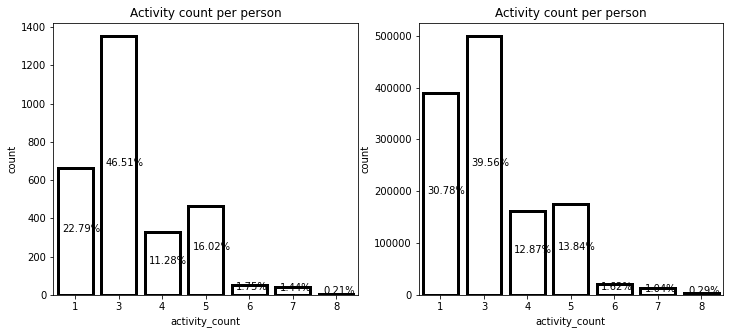

In [30]:
hts_count = get_activity_count(hts_activities, "traveler_id")
df_count = get_activity_count(df_activities, "person_id")

activity_count([hts_count, df_count])

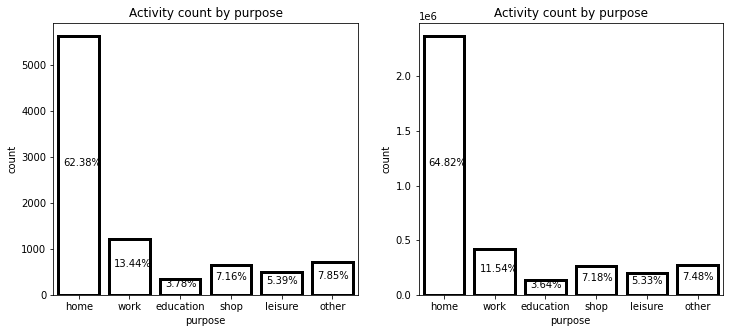

In [31]:
activity_count_purpose([hts_activities, df_activities])

### Comparison: Travel mode

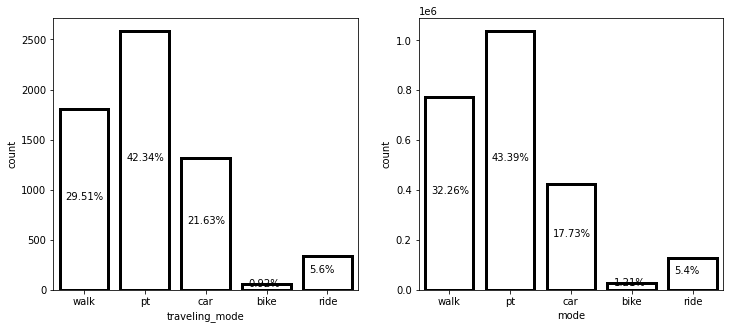

In [32]:
side_by_side_count([hts_joined_dest, df_trips],["traveling_mode","mode"], ["purpose", "following_purpose"])